# About this Notebook
Given the size of both the various embeddings, the datasets (including multiple 'noise'<sup> 1 </sup> test sets), I have created several smaller embedding dedicated notebooks that can be run seperately that allow us to run without reducing embedding sizes or sampling.<br>
<br>

**This notebook is dedicated to only the 'traditional' embedding method subset from our study:**

- CountVectorizer (BoW)
- HashingVector (HV)
- TF-IDF
<br>
<br>

All classifcation models from the main notebook are used:  

- Logistic Regression (LR)
- Naive Bayes (NB)
- Random Forest (RF)
- Support Vector Machine (SVM)
- K-Nearest Neighbour (KNN)
- GradientBoosting (GB)
- Extreme Gradient Boosting (XGB)   
  
<br>


---


  
  

<sup>1  </sup>*Noise levels as introduced by machine backtranslations. 'N0' being the original testset (the version similar to training), 'N1' (1 level of backtranslation (EN -> RU -> EN), continuing to 'N3'.
For rough assessment of noise in a purely lexical sense, the Jaro-Winkler Distances (normalized) have been calculated and imported before and are imported in this notebook*. 
<br>
<br>



# Import + mounting drive

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.csc import csc_matrix
#import matplotlib.pyplot as plt

#preprocessing:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler
#from keras.preprocessing.text import Tokenizer
#from keras.utils import pad_sequences #or: from tensorflow.keras.preprocessing.sequence import pad_sequences


#pickle:
from pickle import dump, load
picklepath = '/content/drive/MyDrive/MYDATA/PickledModels/Dedicated/'

#classifiers:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

#evaluation
from sklearn.metrics import roc_auc_score


#system:
import gc
import sys
from google.colab import drive
import gzip

<ipython-input-1-f13de17bb952>:3: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix


In [2]:
#from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#no need to run this everytime

#!pip install pipreqs
#!pipreqs . 

In [ ]:
# this colab builds on the FULL_CREATION_DataSet.ipynb colab
# link: https://colab.research.google.com/drive/1lFMu0WaWkpDCZpPCH3eC3LJWlYNlbg06?usp=sharing
# this previous colab exports the seperate train and test sets..

# Reading in test & train sets (csv method)

(This version takes in the Stemmed datasets for comparison on AUC ROC)






In [3]:
#nltk.download('punkt')

In [4]:
pathTESTcsv = '/content/drive/MyDrive/MYDATA/DATA/full_TEST_Nx_stemmed.csv' #be mindful, this is Test-INC (as the INC is the one with the translation columns)
pathTRAINcsv = '/content/drive/MyDrive/MYDATA/DATA/full_TRAIN_stemmed.csv' #NTS: this trainset is not capped at 2800 chars.. (the testset is..)

df_test = pd.read_csv(pathTESTcsv)
df_train = pd.read_csv(pathTRAINcsv)

In [5]:
df_test.head()

,text,label,text_N1,text_N2,text_N3
0,trump s weekend trip to mar-a-lago and hi near...,1,trump 's weekend trip to mar-a-lago and it nea...,trump 's weekend trip to mar-a-lago and the ne...,trump 's weekend trip to mar-a-lago and the ne...
1,the british parliament conduct what can onli b...,1,the british parliament held what can onli be d...,the british parliament held what can onli be d...,the british parliament stage what can onli be ...
2,the unit state and china will work togeth to g...,0,the unit state and china will work togeth to f...,the unit state and china will work togeth to f...,the unit state and china will work togeth to f...
3,a feder judg in hawaii issu a nationwid order ...,0,"on wednesday night , a feder judg in hawaii is...","on wednesday night , a feder judg in hawaii is...","on wednesday night , a feder judg in hawaii is..."
4,obama made wall street out to be the enemi dur...,1,obama made wall street hi enemi dure hi presid...,obama made wall street hi enemi dure hi presid...,obama made wall street hi enemi dure hi presid...


In [6]:
#BE AWARE IF UNCOMMENTED:
#df_train = df_train.sample(10000, random_state=42) #smaller for faster testing..

In [7]:
len(df_test[df_test['text_N1'].str.contains('д|и|г')]) #how many rows are not translated back to english correctly? # ± 2.7%

561

# Embedding 0: Assigning the series needed for embedding


*   X_train
*   y_train
*   X_testNx (for N0 to N3)
*   y_test (same for all N's)

In [8]:
X_train = df_train['text']
y_train = df_train['label']
X_testN0 = df_test['text']
X_testN1 = df_test['text_N1']
X_testN2 = df_test['text_N2']
X_testN3 = df_test['text_N3']
y_testALL = df_test['label']

# Embedding 1: BoW (Countvectorizer)

In [9]:
#from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=4, max_df=0.8)
vectorizer.fit(X_train)

CountVectorizer(max_df=0.8, min_df=4)

In [10]:
X_train_BoW = vectorizer.transform(X_train)
# ---
X_testN0_BoW  = vectorizer.transform(X_testN0)
X_testN1_BoW  = vectorizer.transform(X_testN1)
X_testN2_BoW  = vectorizer.transform(X_testN2)
X_testN3_BoW  = vectorizer.transform(X_testN3)

In [11]:
#X_train.shape # <- 67625 by 1
#X_train_BoW.shape # <- 67625 by 60326
#type(X_testN0_BoW) # <- sparse matrix
#type(X_train) #<- series

In [12]:
#n_features = len(X_train)
#print(n_features)

# Embedding 2: HashingVectorizer

In [13]:
#from sklearn.feature_extraction.text import HashingVectorizer
hashingvectorizer = HashingVectorizer(n_features=60326)
hashingvectorizer.fit(X_train)

HashingVectorizer(n_features=60326)

In [14]:
X_train_HV = hashingvectorizer.transform(X_train)
# ---
X_testN0_HV  = hashingvectorizer.transform(X_testN0)
X_testN1_HV  = hashingvectorizer.transform(X_testN1)
X_testN2_HV  = hashingvectorizer.transform(X_testN2)
X_testN3_HV  = hashingvectorizer.transform(X_testN3)

In [15]:
#THIS BLOCK IS ONLY FOR THE NAIVE BAYES CLASSIFIER

#scaling
#minmax would be the go to for sparse data, however our sparse data contains negative values -> MaxAbsScaler

#from sklearn.preprocessing import MaxAbsScaler
MaxAbs_scaler = MaxAbsScaler()

# transform data
# (check whether indeed best to fit scaler only on trainset)
MaxAbs_scaler.fit(X_train_HV)
X_train_HV_scaled = MaxAbs_scaler.transform(X_train_HV)
X_testN0_HV_scaled = MaxAbs_scaler.transform(X_testN0_HV)
X_testN1_HV_scaled = MaxAbs_scaler.transform(X_testN1_HV)
X_testN2_HV_scaled = MaxAbs_scaler.transform(X_testN2_HV)
X_testN3_HV_scaled = MaxAbs_scaler.transform(X_testN3_HV)

#shift +1 for all non-zero values to be usable for Naive Bayes classifier
#from scipy.sparse.csc import csc_matrix
X_train_HV_scaled.data += 1
X_testN0_HV_scaled.data += 1
X_testN1_HV_scaled.data += 1
X_testN2_HV_scaled.data += 1
X_testN3_HV_scaled.data += 1

# Embedding 3: TF-IDF
- Builds on output of BoW countvectorizer (embedding 1)

In [16]:
#from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_BoW)

TfidfTransformer()

In [17]:
X_train_TFIDF = tfidf_transformer.transform(X_train_BoW)
# ---
X_testN0_TFIDF  = tfidf_transformer.transform(X_testN0_BoW)
X_testN1_TFIDF  = tfidf_transformer.transform(X_testN1_BoW)
X_testN2_TFIDF  = tfidf_transformer.transform(X_testN2_BoW)
X_testN3_TFIDF  = tfidf_transformer.transform(X_testN3_BoW)

In [18]:
#X_testN0_TFIDF.shape # <- 684 by 60326
#type(X_testN0_TFIDF) # <- sparse matrix
X_testN0_TFIDF.shape

(21999, 33609)

# Check RAM

In [19]:
# also see del statement under glove embedding code
# and the gc collect

In [20]:
#code snippet to list all self defined vars and their RAM uptake 
#source: https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_test', 223083096),
 ('df_train', 129940098),
 ('X_train', 129529450),
 ('X_testN1', 56058971),
 ('X_testN2', 55725511),
 ('X_testN3', 55598075),
 ('X_testN0', 55524979),
 ('y_train', 410792),
 ('y_testALL', 176136),
 ('CountVectorizer', 1472),
 ('HashingVectorizer', 1472),
 ('TfidfTransformer', 1192),
 ('csc_matrix', 1192),
 ('GradientBoostingClassifier', 1064),
 ('KNeighborsClassifier', 1064),
 ('LogisticRegression', 1064),
 ('MaxAbsScaler', 1064),
 ('MultinomialNB', 1064),
 ('RandomForestClassifier', 1064),
 ('SGDClassifier', 1064),
 ('XGBClassifier', 1064),
 ('roc_auc_score', 136),
 ('pathTESTcsv', 108),
 ('pathTRAINcsv', 106),
 ('picklepath', 103),
 ('drive', 72),
 ('dump', 72),
 ('load', 72),
 ('np', 72),
 ('pd', 72),
 ('MaxAbs_scaler', 48),
 ('X_testN0_BoW', 48),
 ('X_testN0_HV', 48),
 ('X_testN0_HV_scaled', 48),
 ('X_testN0_TFIDF', 48),
 ('X_testN1_BoW', 48),
 ('X_testN1_HV', 48),
 ('X_testN1_HV_scaled', 48),
 ('X_testN1_TFIDF', 48),
 ('X_testN2_BoW', 48),
 ('X_testN2_HV',

# Model 0: Creating lists for iterative model comparisons.

In [21]:
ListTestsets_BoW = [X_testN0_BoW, X_testN1_BoW, X_testN2_BoW, X_testN3_BoW]
ListTestsets_HV = [X_testN0_HV, X_testN1_HV, X_testN2_HV, X_testN3_HV]
ListTestsets_TFIDF = [X_testN0_TFIDF, X_testN1_TFIDF, X_testN2_TFIDF, X_testN3_TFIDF]

ListTestsets_HV_scaled = [X_testN0_HV_scaled, X_testN1_HV_scaled, X_testN2_HV_scaled, X_testN3_HV_scaled]

names_list = ['X_testN0', 'X_testN1', 'X_testN2', 'X_testN3']

# Model 1: Logistics Regression

In [22]:
#from sklearn.linear_model import LogisticRegression
classifierLR = LogisticRegression(solver='lbfgs', max_iter=2000)

In [23]:
#Training the models and pickling each one separately

Model_LR_BoW = classifierLR.fit(X_train_BoW, y_train)
with open(picklepath+"Model_LR_BoW.pkl", "wb") as f:
    dump(Model_LR_BoW, f)

Model_LR_HV = classifierLR.fit(X_train_HV, y_train)
with open(picklepath+"Model_LR_HV.pkl", "wb") as f:
    dump(Model_LR_HV, f)

Model_LR_TFIDF = classifierLR.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_LR_TFIDF.pkl", "wb") as f:
    dump(Model_LR_TFIDF, f)

Comparing results Logistic regression with BoW. 

- (N0 (base), N1, N2 and N3)

In [24]:
with open(picklepath + 'Model_LR_BoW.pkl', 'rb') as f:
  Model_LR_BoW = load(f)
  score_test = Model_LR_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + LR): {score_test}') #.9966..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_LR_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)    
    #score_test = Model_LR_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (BoW + LR): 0.9911749235354854
AUC score for BoW + LogisticRegression on X_testN0 (1%split): 0.9222059014388797
AUC score for BoW + LogisticRegression on X_testN1 (1%split): 0.8558367521958063
AUC score for BoW + LogisticRegression on X_testN2 (1%split): 0.8540397539290767
AUC score for BoW + LogisticRegression on X_testN3 (1%split): 0.8534974927052842


Comparing results Logistic regression with HashingVectorizer.

(N0 (base), N1, N2 and N3)

In [25]:
with open(picklepath+ 'Model_LR_HV.pkl', 'rb') as f:
  Model_LR_HV = load(f)
  score_test = Model_LR_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + LR): {score_test}') #.9216..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_LR_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred) 
    #score_test = Model_LR_HV.score(i, y_testALL)
    print(f'AUC score for HV + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (HV + LR): 0.9155675907346438
AUC score for HV + LogisticRegression on X_testN0 (1%split): 0.9055239761440032
AUC score for HV + LogisticRegression on X_testN1 (1%split): 0.8621079058609623
AUC score for HV + LogisticRegression on X_testN2 (1%split): 0.8595740733795361
AUC score for HV + LogisticRegression on X_testN3 (1%split): 0.8589931801298669


Comparing results Logistic regression with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [26]:
with open(picklepath + 'Model_LR_TFIDF.pkl', 'rb') as f:
  Model_LR_TFIDF = load(f)
  score_test = Model_LR_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + LR): {score_test}') #.9510..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_LR_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_LR_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (TFIDF + LR): 0.9449845122830258
AUC score for TFIDF + LogisticRegression on X_testN0 (1%split): 0.9268003365146114
AUC score for TFIDF + LogisticRegression on X_testN1 (1%split): 0.880960678381689
AUC score for TFIDF + LogisticRegression on X_testN2 (1%split): 0.8776220037412573
AUC score for TFIDF + LogisticRegression on X_testN3 (1%split): 0.8766223938567688


Comparing results Logistic regression with GloVe.

(N0 (base), N1, N2 and N3)

# Model 2: Naive Bayes

In [27]:
#why MultinomialNB instead of Gaussian? GaussianNN seemed to need dense matrix as input and that kept overloading RAM
#as train set is about 60k by 67k which is fine for sparse but giant in dense matrix (see code at the bottom with failed attempts to use .todense function).
#from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()

In [28]:
#Training the models and pickling each one separately

Model_NB_BoW = classifierNB.fit(X_train_BoW, y_train, sample_weight=None)
with open(picklepath+"Model_NB_BoW.pkl", "wb") as f:
    dump(Model_NB_BoW, f)

Model_NB_HV = classifierNB.fit(X_train_HV_scaled, y_train, sample_weight=None)
with open(picklepath+"Model_NB_HV.pkl", "wb") as f:
    dump(Model_NB_HV, f)

Model_NB_TFIDF = classifierNB.fit(X_train_TFIDF, y_train, sample_weight=None)
with open(picklepath+"Model_NB_TFIDF.pkl", "wb") as f:
    dump(Model_NB_TFIDF, f)

Comparing results Naive Bayes with BoW. 

- (N0 (base), N1, N2 and N3)




In [29]:
with open(picklepath + 'Model_NB_BoW.pkl', 'rb') as f:
  Model_NB_BoW = load(f)
  score_test = Model_NB_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + NB): {score_test}') #.8730..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_NB_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (BoW + NB): 0.8521166546531336
AUC score for BoW + Naive Bayes on X_testN0 (1%split): 0.8376274241575521
AUC score for BoW + Naive Bayes on X_testN1 (1%split): 0.7972451611730275
AUC score for BoW + Naive Bayes on X_testN2 (1%split): 0.7952089169742741
AUC score for BoW + Naive Bayes on X_testN3 (1%split): 0.7948195762578874


Comparing results Naive Bayes with HV. 

- (N0 (base), N1, N2 and N3)


In [30]:
#this block uses the scaled input (MaxAbs scaler with a +1 shift for all nonzero values..)
with open(picklepath + 'Model_NB_HV.pkl', 'rb') as f:
  Model_NB_HV = load(f)
  score_test = Model_NB_HV.score(X_train_HV_scaled, y_train)
  print(f'Model overfit check (HV + NB): {score_test}') #.8682..
  for i, name in zip(ListTestsets_HV_scaled, names_list):
    y_pred = Model_NB_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (HV + NB): 0.8560518984629172
AUC score for HashingVectors + Naive Bayes on X_testN0 (1%split): 0.8301220427296059
AUC score for HashingVectors + Naive Bayes on X_testN1 (1%split): 0.7856018646722619
AUC score for HashingVectors + Naive Bayes on X_testN2 (1%split): 0.7837988254902891
AUC score for HashingVectors + Naive Bayes on X_testN3 (1%split): 0.784283942473317


Comparing results Naive Bayes with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [31]:
with open(picklepath + 'Model_NB_TFIDF.pkl', 'rb') as f:
  Model_NB_TFIDF = load(f)
  score_test = Model_NB_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + NB): {score_test}') #.8753..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_NB_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (TFIDF + NB): 0.8728838323819914
AUC score for TFIDF + Naive Bayes on X_testN0 (1%split): 0.8550596286396659
AUC score for TFIDF + Naive Bayes on X_testN1 (1%split): 0.8132298579519799
AUC score for TFIDF + Naive Bayes on X_testN2 (1%split): 0.8130165780116088
AUC score for TFIDF + Naive Bayes on X_testN3 (1%split): 0.8121698886345261


# Model 3: Random Forest




In [32]:
#from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators= 20, max_depth = 8, min_samples_split=3)

In [ ]:
#still to do:
# add n_estimators’ and ‘max_features’ etc to prevent overfitting.. 
# Prioritize speed of training over precision for now! (running this now takes about 15 minutes, with n_estimators at 20, this is about 2 minutes)

In [33]:
#Training the models and pickling each one separately

Model_RF_BoW = classifierRF.fit(X_train_BoW, y_train)
with open(picklepath+"Model_RF_BoW.pkl", "wb") as f:
    dump(Model_RF_BoW, f)

Model_RF_HV = classifierRF.fit(X_train_HV_scaled, y_train)
with open(picklepath+"Model_RF_HV.pkl", "wb") as f:
    dump(Model_RF_HV, f)
# -> Negative values in data passed to MultinomialNB (input X)

Model_RF_TFIDF = classifierRF.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_RF_TFIDF.pkl", "wb") as f:
    dump(Model_RF_TFIDF, f)

Comparing results Random Forest with BoW. 

- (N0 (base), N1, N2 and N3)

In [34]:
with open(picklepath + 'Model_RF_BoW.pkl', 'rb') as f:
  Model_RF_BoW = load(f)
  score_test = Model_RF_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + RF): {score_test}') #.999..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_RF_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + Random Forest on {name} (1%split): {score_test}')

Model overfit check (BoW + RF): 0.805672985135688
AUC score for BoW + Random Forest on X_testN0 (1%split): 0.7914286257411701
AUC score for BoW + Random Forest on X_testN1 (1%split): 0.7519966716462922
AUC score for BoW + Random Forest on X_testN2 (1%split): 0.7528107699127419
AUC score for BoW + Random Forest on X_testN3 (1%split): 0.7524600612222314


Comparing results Random Forest with HV. 

- (N0 (base), N1, N2 and N3)

In [35]:
with open(picklepath + 'Model_RF_HV.pkl', 'rb') as f:
  Model_RF_HV = load(f)
  score_test = Model_RF_HV.score(X_train_HV_scaled, y_train)
  print(f'Model overfit check (HV + RF): {score_test}') #.999..
  for i, name in zip(ListTestsets_HV_scaled, names_list):
    y_pred = Model_RF_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_HV.score(i, y_testALL)
    print(f'AUC score for HV + Random Forest on {name} (1%split): {score_test}')

Model overfit check (HV + RF): 0.8188034521049659
AUC score for HV + Random Forest on X_testN0 (1%split): 0.8005104664532895
AUC score for HV + Random Forest on X_testN1 (1%split): 0.7695185161841588
AUC score for HV + Random Forest on X_testN2 (1%split): 0.7679285622079779
AUC score for HV + Random Forest on X_testN3 (1%split): 0.7670448484011189


Comparing results Random Forest with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [36]:
with open(picklepath + 'Model_RF_TFIDF.pkl', 'rb') as f:
  Model_RF_TFIDF = load(f)
  score_test = Model_RF_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + RF): {score_test}') #.999..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_RF_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + Random Forest on {name} (1%split): {score_test}')

Model overfit check (TFIDF + RF): 0.8061600202606612
AUC score for TFIDF + Random Forest on X_testN0 (1%split): 0.7841433938266221
AUC score for TFIDF + Random Forest on X_testN1 (1%split): 0.7546373885519503
AUC score for TFIDF + Random Forest on X_testN2 (1%split): 0.7544269343346215
AUC score for TFIDF + Random Forest on X_testN3 (1%split): 0.7543665749016562


# Model 4: SupportVectorMachine

In [52]:
#from sklearn.linear_model import SGDClassifier
classifierSVM = SGDClassifier(loss='hinge', penalty='l2', random_state=42, alpha=0.0015)

In [53]:
#Training the models and pickling each one separately

Model_SVM_BoW = classifierSVM.fit(X_train_BoW, y_train)
with open(picklepath+"Model_SVM_BoW.pkl", "wb") as f:
    dump(Model_SVM_BoW, f)

Model_SVM_HV = classifierSVM.fit(X_train_HV_scaled, y_train)
with open(picklepath+"Model_SVM_HV.pkl", "wb") as f:
    dump(Model_SVM_HV, f)

Model_SVM_TFIDF = classifierSVM.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_SVM_TFIDF.pkl", "wb") as f:
    dump(Model_SVM_TFIDF, f)

Comparing results SVM with BoW. 

- (N0 (base), N1, N2 and N3)

In [54]:
with open(picklepath + 'Model_SVM_BoW.pkl', 'rb') as f:
  Model_SVM_BoW = load(f)
  score_test = Model_SVM_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + SVM): {score_test}')
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_SVM_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + SVM on {name} (1%split): {score_test}')

Model overfit check (BoW + SVM): 0.9573941672673433
AUC score for BoW + SVM on X_testN0 (1%split): 0.9243115664434634
AUC score for BoW + SVM on X_testN1 (1%split): 0.8659785622253797
AUC score for BoW + SVM on X_testN2 (1%split): 0.8647872050730296
AUC score for BoW + SVM on X_testN3 (1%split): 0.8629256087887709


Comparing results SVM with HV. 

- (N0 (base), N1, N2 and N3)

In [55]:
with open(picklepath + 'Model_SVM_HV.pkl', 'rb') as f:
  Model_SVM_HV = load(f)
  score_test = Model_SVM_HV.score(X_train_HV_scaled, y_train)
  print(f'Model overfit check (HV + SVM): {score_test}')
  for i, name in zip(ListTestsets_HV_scaled, names_list):
    y_pred = Model_SVM_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + SVM on {name} (1%split): {score_test}')

Model overfit check (HV + SVM): 0.954764177592488
AUC score for HashingVectors + SVM on X_testN0 (1%split): 0.926767745403978
AUC score for HashingVectors + SVM on X_testN1 (1%split): 0.8672630646559076
AUC score for HashingVectors + SVM on X_testN2 (1%split): 0.8649656523834626
AUC score for HashingVectors + SVM on X_testN3 (1%split): 0.8650753128112697


Comparing results SVM with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [56]:
with open(picklepath + 'Model_SVM_TFIDF.pkl', 'rb') as f:
  Model_SVM_TFIDF = load(f)
  score_test = Model_SVM_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + SVM): {score_test}') #.934..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_SVM_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + SVM on {name} (1%split): {score_test}')

Model overfit check (TFIDF + SVM): 0.8827219419064503
AUC score for TFIDF + SVM on X_testN0 (1%split): 0.8779986784234203
AUC score for TFIDF + SVM on X_testN1 (1%split): 0.8445221966677052
AUC score for TFIDF + SVM on X_testN2 (1%split): 0.8428334459672615
AUC score for TFIDF + SVM on X_testN3 (1%split): 0.8428797265044817


# Model 5: K NearestNeighbour (KNN)

In [60]:
classifierKNN = KNeighborsClassifier(n_neighbors=6, leaf_size=8, weights='uniform')
#remember: training KNN is fast, scoring is slow and RAM intensive.
#also.. these have giant pickle models (.pkl's) so change parameters a bit here..

In [61]:
#Training the models and pickling each one separately

Model_KNN_BoW = classifierKNN.fit(X_train_BoW, y_train)
with open(picklepath+"Model_KNN_BoW.pkl", "wb") as f:
    dump(Model_KNN_BoW, f)

Model_KNN_HV = classifierKNN.fit(X_train_HV, y_train)
with open(picklepath+"Model_KNN_HV.pkl", "wb") as f:
    dump(Model_KNN_HV, f)

Model_KNN_TFIDF = classifierKNN.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_KNN_TFIDF.pkl", "wb") as f:
    dump(Model_KNN_TFIDF, f)

Comparing results KNN with BoW. 

- (N0 (base), N1, N2 and N3)

In [62]:
with open(picklepath + 'Model_KNN_BoW.pkl', 'rb') as f:
  Model_KNN_BoW = load(f)
  score_test = Model_KNN_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + KNN): {score_test}')
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_KNN_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + KNN on {name} (1%split): {score_test}')

Model overfit check (BoW + KNN): 0.8068029066256258
AUC score for BoW + KNN on X_testN0 (1%split): 0.7386445999297399
AUC score for BoW + KNN on X_testN1 (1%split): 0.7025000721346601
AUC score for BoW + KNN on X_testN2 (1%split): 0.6989143083162819
AUC score for BoW + KNN on X_testN3 (1%split): 0.6979919624835464


Comparing results KNN with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_HV.pkl', 'rb') as f:
  Model_KNN_HV = load(f)
  score_test = Model_KNN_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + KNN): {score_test}') #.898..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_KNN_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + KNN on {name} (1%split): {score_test}')

Model overfit check (HV + KNN): 0.8975862539206327
AUC score for HashingVectors + KNN on X_testN0 (1%split): 0.8013677750798707
AUC score for HashingVectors + KNN on X_testN1 (1%split): 0.7639576465383094
AUC score for HashingVectors + KNN on X_testN2 (1%split): 0.7639791792108191
AUC score for HashingVectors + KNN on X_testN3 (1%split): 0.7640162036405953


Comparing results KNN with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_TFIDF.pkl', 'rb') as f:
  Model_KNN_TFIDF = load(f)
  score_test = Model_KNN_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + KNN): {score_test}') #.890..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_KNN_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + KNN on {name} (1%split): {score_test}')

Model overfit check (TFIDF + KNN): 0.9075217704700863
AUC score for TFIDF + KNN on X_testN0 (1%split): 0.8196101334173835
AUC score for TFIDF + KNN on X_testN1 (1%split): 0.79131560510605
AUC score for TFIDF + KNN on X_testN2 (1%split): 0.789911162747908


# Model 6. GradientBoosting

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
classifierGB = GradientBoostingClassifier(learning_rate=0.3, max_depth=2)
#change from 0.1 to 0.2 to save time when testing.. (NOTE: takes long time still at .2..)

In [ ]:
#Training the models and pickling each one separately

Model_GB_BoW = classifierGB.fit(X_train_BoW, y_train)
with open(picklepath+"Model_GB_BoW.pkl", "wb") as f:
    dump(Model_GB_BoW, f)

Model_GB_HV = classifierGB.fit(X_train_HV, y_train)
with open(picklepath+"Model_GB_HV.pkl", "wb") as f:
    dump(Model_GB_HV, f)

Model_GB_TFIDF = classifierGB.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_GB_TFIDF.pkl", "wb") as f:
    dump(Model_GB_TFIDF, f)

Comparing results GradientBoosting with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_BoW.pkl', 'rb') as f:
  Model_GB_BoW = load(f)
  score_test = Model_GB_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + GB): {score_test}') #.9096..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_GB_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + GB on {name} (1%split): {score_test}')

Comparing results GradientBoosting with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_HV.pkl', 'rb') as f:
  Model_GB_HV = load(f)
  score_test = Model_GB_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + GB): {score_test}') #.8668..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_GB_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + GB on {name} (1%split): {score_test}')

Comparing results GradientBoosting with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_TFIDF.pkl', 'rb') as f:
  Model_GB_TFIDF = load(f)
  score_test = Model_GB_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + GB): {score_test}') #.8907..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_GB_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + GB on {name} (1%split): {score_test}')

# Model 7. XGBoost (extreme gradient boosting)

In [ ]:
#from xgboost import XGBClassifier

In [ ]:
classifierXGB = XGBClassifier(learning_rate=0.2, max_depth=2)

In [ ]:
#Training the models and pickling each one separately

Model_XGB_BoW = classifierXGB.fit(X_train_BoW, y_train)
with open(picklepath+"Model_XGB_BoW.pkl", "wb") as f:
    dump(Model_XGB_BoW, f)

Model_XGB_HV = classifierXGB.fit(X_train_HV, y_train)
with open(picklepath+"Model_XGB_HV.pkl", "wb") as f:
    dump(Model_XGB_HV, f)

Model_XGB_TFIDF = classifierXGB.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_XGB_TFIDF.pkl", "wb") as f:
    dump(Model_XGB_TFIDF, f)

Comparing results XGB with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_BoW.pkl', 'rb') as f:
  Model_XGB_BoW = load(f)
  score_test = Model_XGB_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + XGB): {score_test}') #.9096..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_XGB_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + XGB on {name} (1%split): {score_test}')

Comparing results XGB with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_HV.pkl', 'rb') as f:
  Model_XGB_HV = load(f)
  score_test = Model_XGB_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + XGB): {score_test}') #.8668..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_XGB_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + XGB on {name} (1%split): {score_test}')

Comparing results XGB with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_TFIDF.pkl', 'rb') as f:
  Model_XGB_TFIDF = load(f)
  score_test = Model_XGB_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + XGB): {score_test}') #.8907..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_XGB_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + XGB on {name} (1%split): {score_test}')

# Noise Proxy
- JaroWinkler (and Hamming) Distance as proxy for 'Noise'. 
- Calculated in separate notebook, imported from csv.

In [ ]:
pathJWdist = '/content/drive/MyDrive/MYDATA/LexicalDistanceJW.csv'
pathHamdist = '/content/drive/MyDrive/MYDATA/LexicalDistanceHAMMING.csv'

In [ ]:
df_JaroWinkler = pd.read_csv(pathJWdist)
df_Hamming = pd.read_csv(pathHamdist)

In [ ]:
#display(df_JaroWinkler.describe())

In [ ]:
#display(df_Hamming.describe())

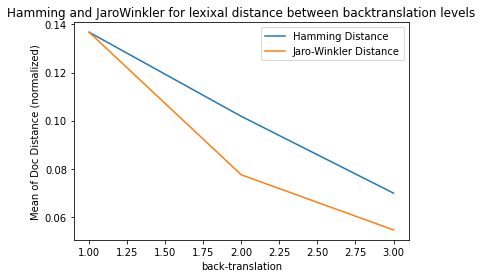

In [ ]:
#values taken from the describe method commented out above

# line 1 points
x1 = [1,2,3]
y1 = [0.136735,0.101772,0.069857]
# plotting the line 1 points 
plt.plot(x1, y1, label = "Hamming Distance")
# line 2 points
x2 = [1,2,3]
y2 = [0.136735,0.077469,0.054566]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Jaro-Winkler Distance")
plt.xlabel('back-translation')
# Set the y axis label of the current axis.
plt.ylabel('Mean of Doc Distance (normalized)')
# Set a title of the current axes.
plt.title('Hamming and JaroWinkler for lexixal distance between backtranslation levels')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

# (Table)

In [ ]:
#total RAM (at 50dim, 80 maxlength, train at 20k, exlcuding KNN) is : 25.6GB
#total RAM (at 50dim, 80 maxlength, train at 20k, exlcuding KNN pretrained models) is : 27GB
#total RAM (at 50dim, 80 maxlength, train at 20k) is 29.5GB:

| Algorithm | Vectorizer | N0 | N1 | N2 | N3 |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | BoW | .843 | .843 |  .843 |  .843 |
| Logistic Regression | HV | .843 | .843 |  .843 |  .843 |
| Logistic Regression | TFIDF | .843 | .843 |  .843 |  .843 |
| Logistic Regression | GloVe | .843 | .843 |  .843 |  .843 |
| Logistic Regression | w2v | .843 | .843 |  .843 |  .843 |
| Logistic Regression | FastText | .843 | .843 |  .843 |  .843 |
| Naive Bayes | BoW | .843 | .843 |  .843 |  .843 |
| Naive Bayes | HV | .843 | .843 |  .843 |  .843 |
| Naive Bayes | TFIDF | .843 | .843 |  .843 |  .843 |
| Naive Bayes | GloVe | .843 | .843 |  .843 |  .843 |
| Naive Bayes | w2v | .843 | .843 |  .843 |  .843 |
| Naive Bayes | FastText | .843 | .843 |  .843 |  .843 |
| Random Forest | BoW | .843 | .843 |  .843 |  .843 |
| Random Forest | HV | .843 | .843 |  .843 |  .843 |
| Random Forest | TFIDF | .843 | .843 |  .843 |  .843 |
| Random Forest | GloVe | .843 | .843 |  .843 |  .843 |
| Random Forest | w2v | .843 | .843 |  .843 |  .843 |
| Random Forest | FastText | .843 | .843 |  .843 |  .843 |
| etc | etc | .843 | .843 |  .843 |  .843 |
